In [1]:
import os
import numpy as np
import cupy as cp
# import numba as nb
import datetime as dt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import h5py
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape
from keras.models import Sequential
from keras.optimizers import Adam
# from attention import Attention

In [2]:
len(tf.config.list_physical_devices('GPU'))

1

In [3]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [4]:
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))
tf.test.is_gpu_available

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [5]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [8]:
tf.config.experimental.enable_op_determinism()

In [9]:
df = pd.read_csv('F:\Work\Time Series Forecast_Water Levels\Impute_misvalues_hungyen.csv')
df.head()

,Date,Hour,Waterlevel
0,1/1/2008,0,47.0
1,1/1/2008,1,43.0
2,1/1/2008,2,40.0
3,1/1/2008,3,37.0
4,1/1/2008,4,34.0


In [10]:
df['Hour'] = df['Hour'].replace('#NUM!', 0)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64061 entries, 0 to 64060
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        64061 non-null  object 
 1   Hour        64061 non-null  object 
 2   Waterlevel  64061 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.5+ MB


In [12]:
df.describe()

,Waterlevel
count,64061.000000
mean,138.135113
std,97.020489
min,-26.000000
25%,75.000000
50%,116.000000
75%,171.000000
max,651.000000


In [13]:
df.isnull().sum()

Date          0
Hour          0
Waterlevel    0
dtype: int64

In [14]:
df['Hour'] = pd.to_datetime(df['Hour'], format='%H', errors='coerce').dt.time
df.head()

,Date,Hour,Waterlevel
0,1/1/2008,00:00:00,47.0
1,1/1/2008,01:00:00,43.0
2,1/1/2008,02:00:00,40.0
3,1/1/2008,03:00:00,37.0
4,1/1/2008,04:00:00,34.0


In [15]:
df['Hour'] = df['Hour'].astype(str)


df['DateTime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Hour']
        )
df = df.set_index('DateTime')
df.drop(['Date', 'Hour'], 
        axis = 1, inplace = True)

df.head()

,Waterlevel
DateTime,
2008-01-01 00:00:00,47.0
2008-01-01 01:00:00,43.0
2008-01-01 02:00:00,40.0
2008-01-01 03:00:00,37.0
2008-01-01 04:00:00,34.0


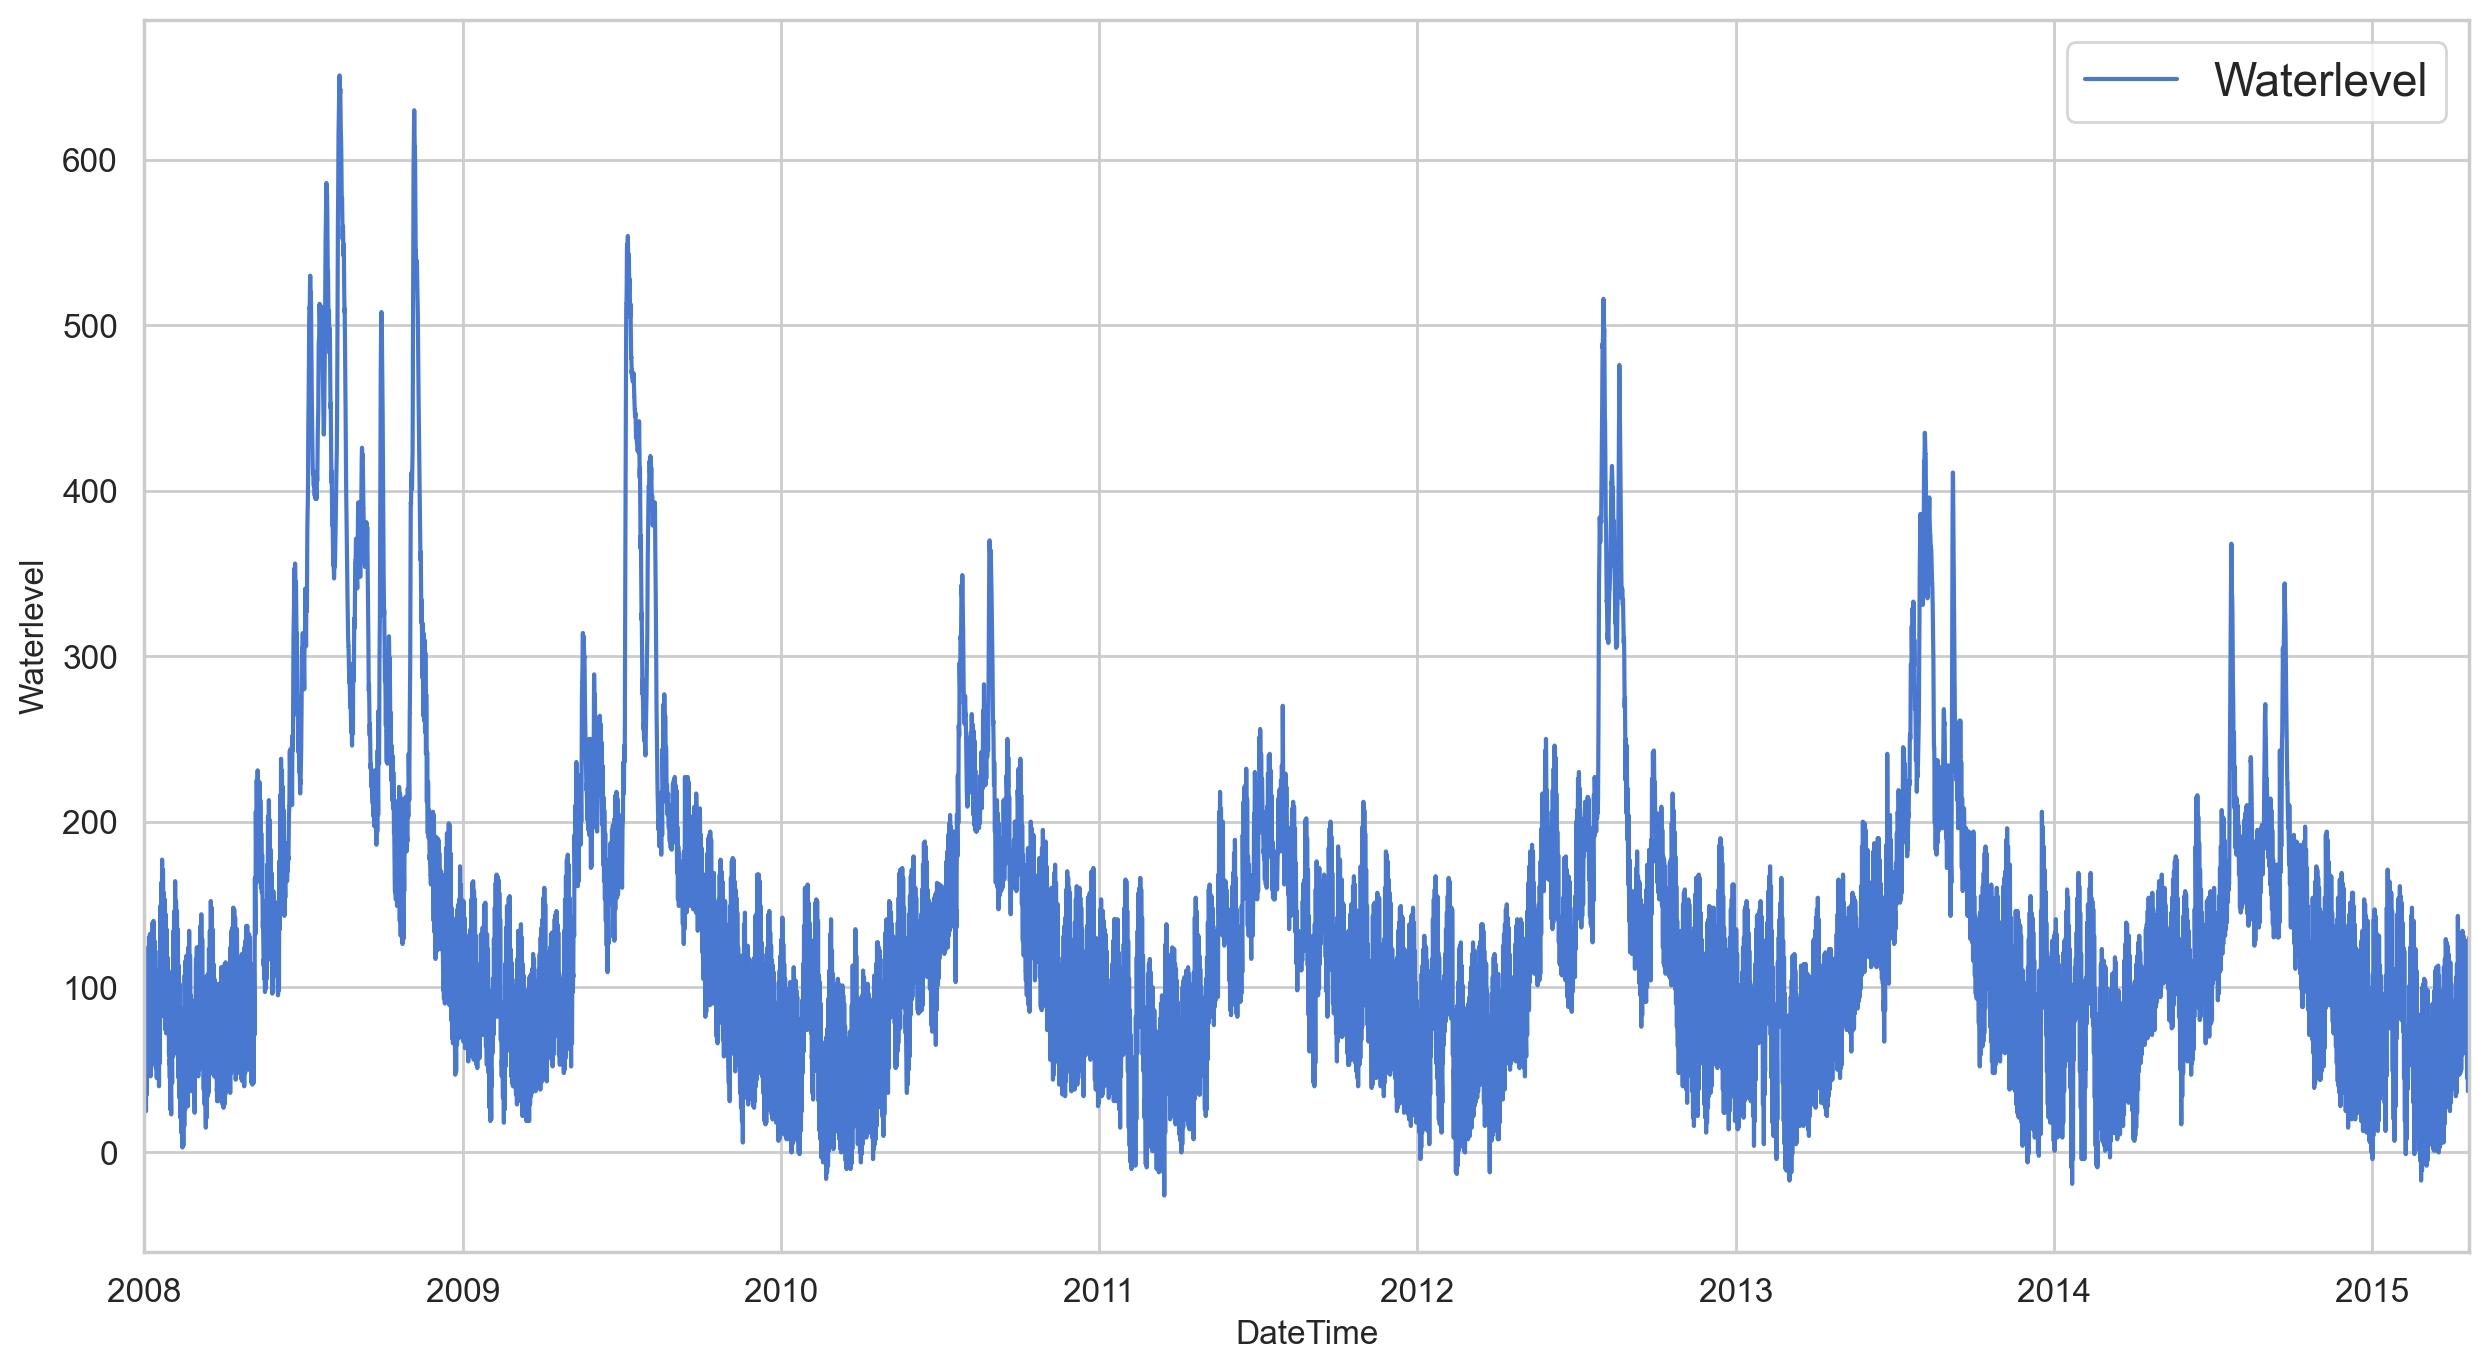

In [16]:
df.plot(y='Waterlevel', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Waterlevel', fontsize=12)
plt.show()

In [17]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.85)
train, val, test = df[:train_size].iloc[:, [-1]], df[train_size:val_size].iloc[:, [-1]] , df[val_size:].iloc[:, [-1]]

train, val, test

(                     Waterlevel
 DateTime                       
 2008-01-01 00:00:00        47.0
 2008-01-01 01:00:00        43.0
 2008-01-01 02:00:00        40.0
 2008-01-01 03:00:00        37.0
 2008-01-01 04:00:00        34.0
 ...                         ...
 2013-02-11 05:00:00        86.0
 2013-02-11 06:00:00       100.0
 2013-02-11 07:00:00       115.0
 2013-02-11 08:00:00       128.0
 2013-02-11 09:00:00       134.0
 
 [44842 rows x 1 columns],
                      Waterlevel
 DateTime                       
 2013-02-11 10:00:00       133.0
 2013-02-11 11:00:00       127.0
 2013-02-11 12:00:00       122.0
 2013-02-11 13:00:00       115.0
 2013-02-11 14:00:00       107.0
 ...                         ...
 2014-03-18 14:00:00        46.0
 2014-03-18 15:00:00        54.0
 2014-03-18 16:00:00        61.0
 2014-03-18 17:00:00        65.0
 2014-03-18 18:00:00        65.0
 
 [9609 rows x 1 columns],
                      Waterlevel
 DateTime                       
 2014-03-18 19:00:0

In [18]:
train.shape, val.shape, test.shape

((44842, 1), (9609, 1), (9610, 1))

Text(0, 0.5, 'Waterlevel')

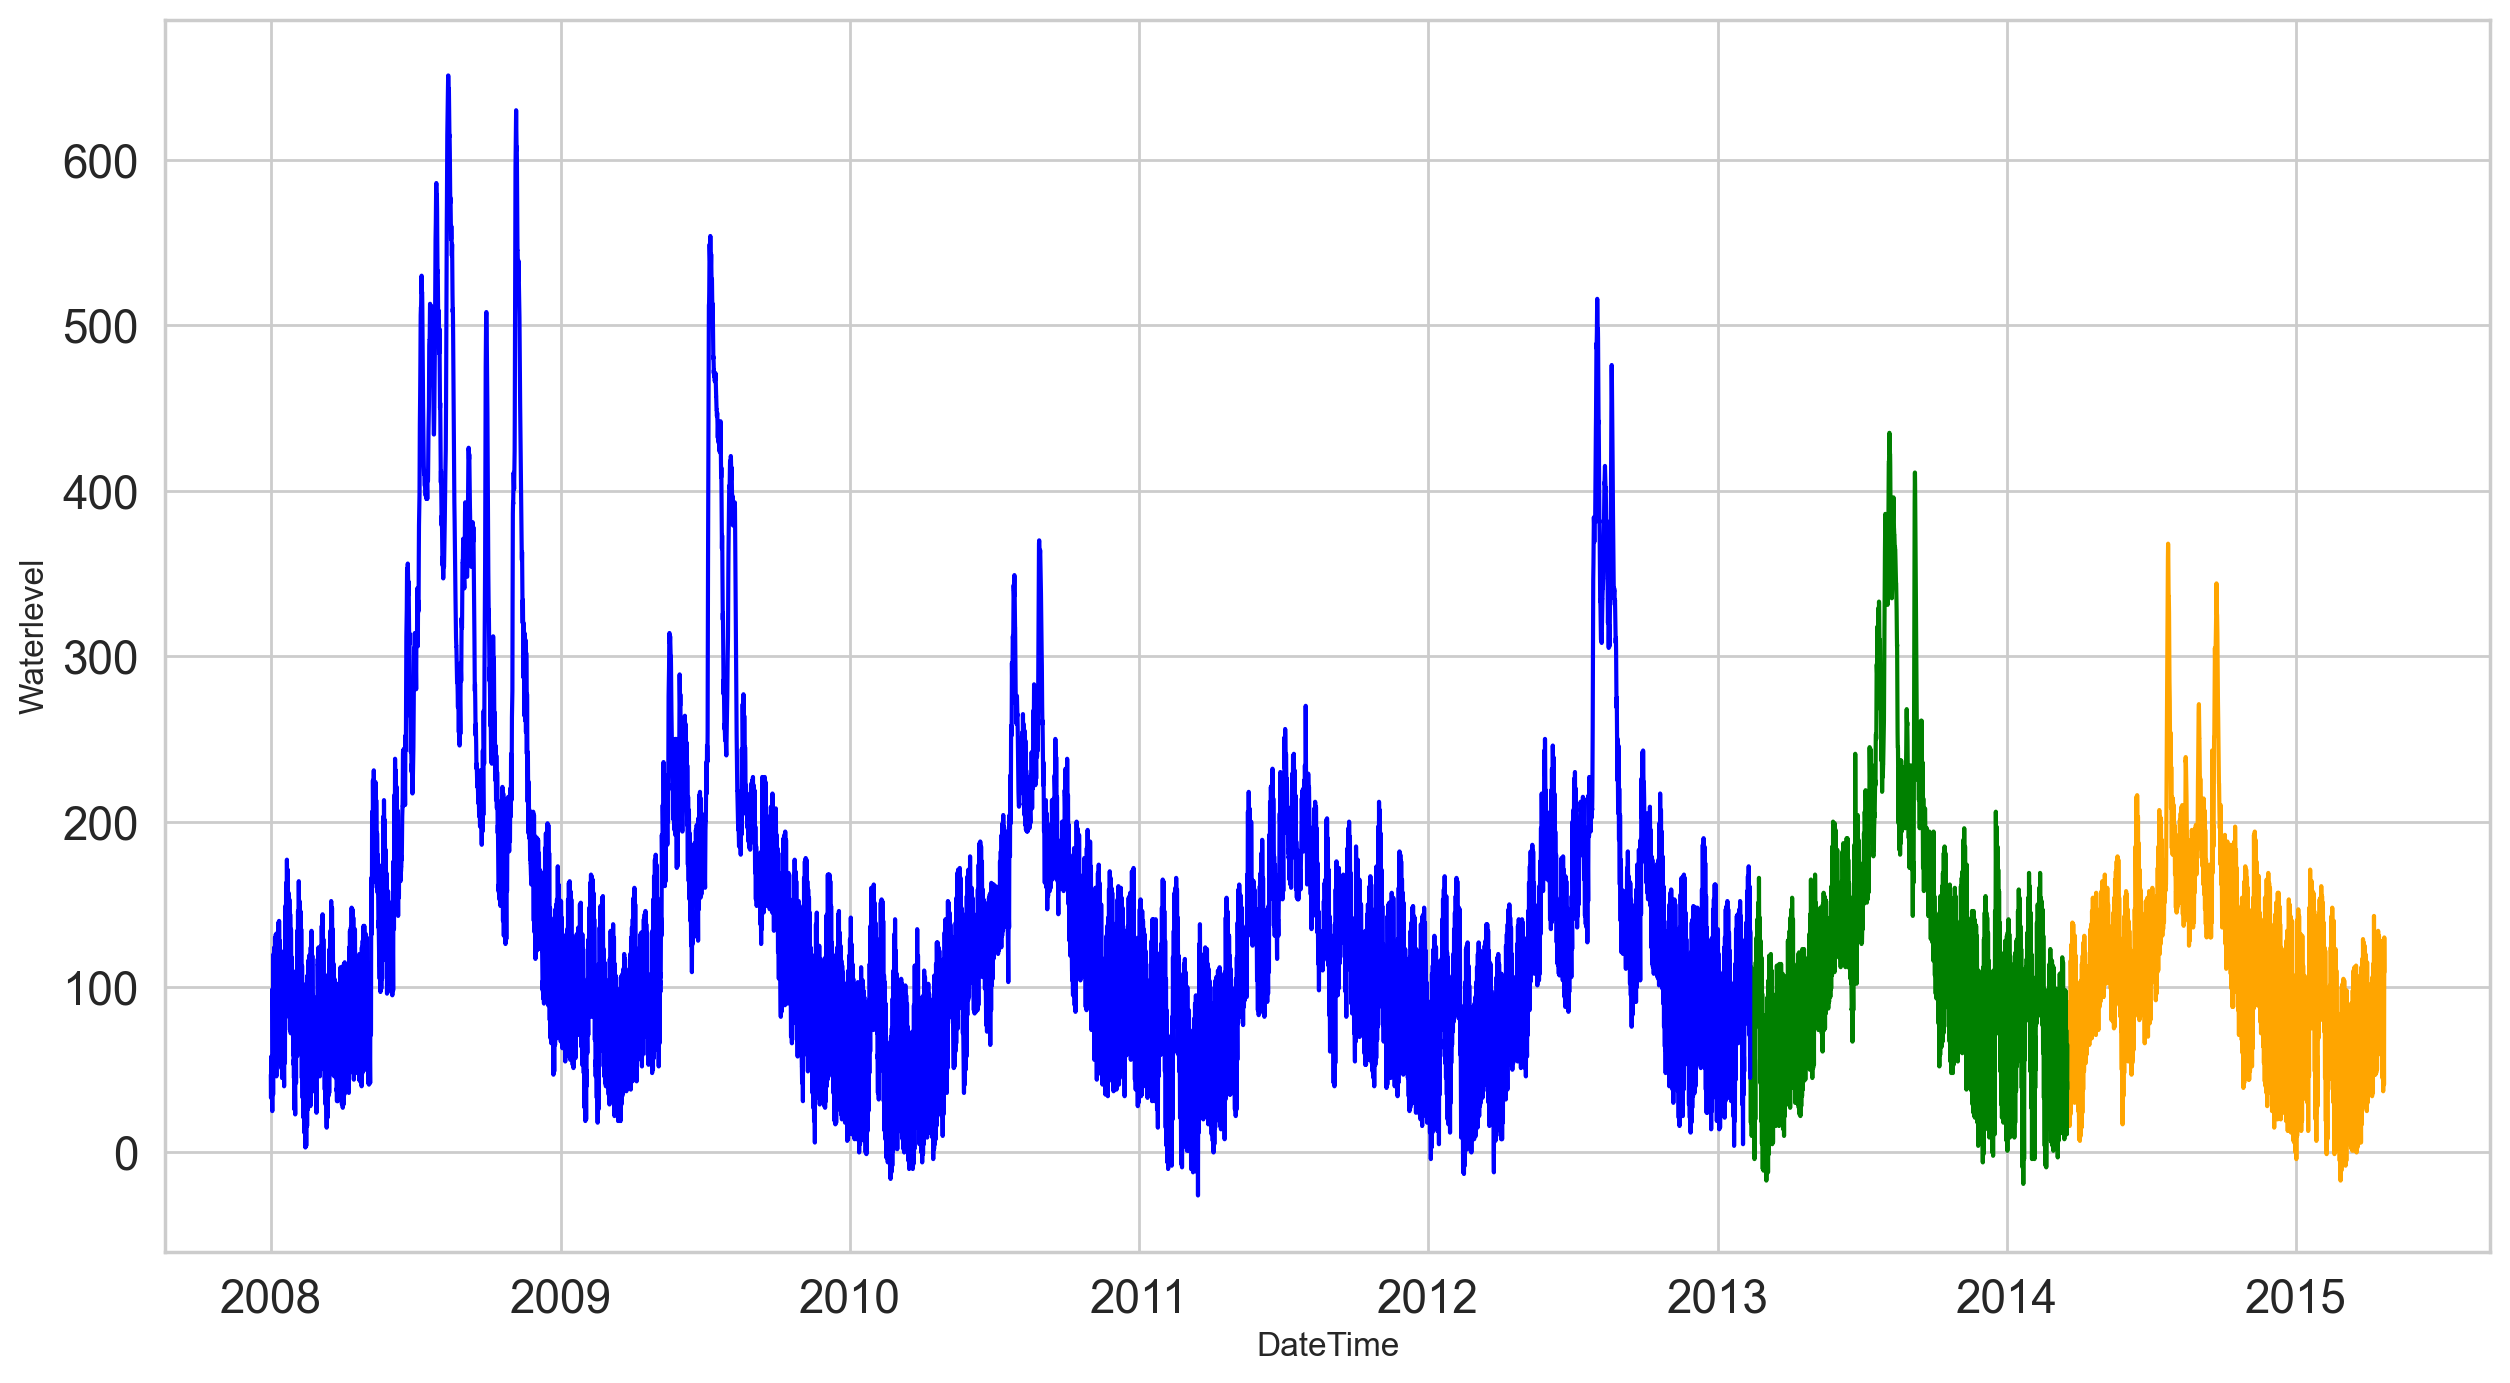

In [19]:
plt.figure(figsize = (15,8))
plt.plot(test.index, test['Waterlevel'], label = "test", color = 'orange')
plt.plot(val.index, val['Waterlevel'], label = "val", color = 'green')
plt.plot(train.index, train['Waterlevel'], label = "train" , color = 'blue')
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Waterlevel', fontsize=12)

In [20]:
scaler = MinMaxScaler()
train['Waterlevel'] = scaler.fit_transform(train)
val['Waterlevel'] = scaler.transform(val)
test['Waterlevel'] = scaler.transform(test)

In [21]:
train_data = train.values
val_data = val.values
test_data = test.values

In [22]:
timesteps = 164

In [23]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] 
                               for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
val_data_timesteps=np.array([[j for j in val_data[i:i+timesteps]] 
                             for i in range(0,len(val_data)-timesteps+1)])[:,:,0]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] 
                              for i in range(0,len(test_data)-timesteps+1)])[:,:,0]


In [24]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_val, y_val = val_data_timesteps[:,:timesteps-1],val_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

x_train, y_train

(array([[0.10782866, 0.10192024, 0.09748892, ..., 0.17282127, 0.16395864,
         0.15509601],
        [0.10192024, 0.09748892, 0.09305761, ..., 0.16395864, 0.15509601,
         0.14623338],
        [0.09748892, 0.09305761, 0.08862629, ..., 0.15509601, 0.14623338,
         0.13737075],
        ...,
        [0.1816839 , 0.17725258, 0.17282127, ..., 0.14327917, 0.16543575,
         0.18611521],
        [0.17725258, 0.17282127, 0.16838996, ..., 0.16543575, 0.18611521,
         0.20827179],
        [0.17282127, 0.16838996, 0.16395864, ..., 0.18611521, 0.20827179,
         0.22747415]]),
 array([[0.14623338],
        [0.13737075],
        [0.12998523],
        ...,
        [0.20827179],
        [0.22747415],
        [0.23633678]]))

In [25]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    squared_error = np.mean((y_true - y_pred)**2)

    r, _ = pearsonr(y_true, y_pred)
    
    T = len(y_true)
    max_x = max(y_true)
    min_x = min(y_true)
    
    sim_sum = 0
    for i in range(T):
        sim_sum += 1 / (1 + abs(y_pred[i] - y_true[i]) / (max_x - min_x))
    sim = sim_sum / T
    
    sd_y = np.std(y_pred)
    sd_x = np.std(y_test)
    fsd = 2 * np.abs(sd_y - sd_x) / (sd_y + sd_x)
    
    nse = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MSE' : squared_error,
        'R': r,
        'SIM': sim,
        'FSD': fsd,
        'NSE': nse
    }

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [28]:
# time = int(input("Enter the first time you want to forecast:"))
time = 0
hours = 120
pred = []

def forecast(model, hours, time):
    pred = []
    # current_window = x_val[-1,:].tolist()
    current_window = x_test[time,:].tolist()
    for i in range(hours):
        y_pred = model.predict(np.asarray([current_window]))[0]
        pred.append(float(y_pred[0]))
        current_window.pop(0)
        current_window.append(pred[-1])
    pred_array = np.array(pred).reshape(-1, 1)
    return pred_array

In [29]:
model = keras.Sequential()

model.add(keras.layers.LSTM(units=512, activation = 'tanh',
                            return_sequences=True, 
                            input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(keras.layers.LSTM(units=256,activation = 'tanh',
                            return_sequences=True))
model.add(Dropout(0.1))
model.add(keras.layers.LSTM(units=64,activation = 'tanh',
                            return_sequences=True))
model.add(Dropout(0.1))
model.add(keras.layers.LSTM(units=32,activation = 'tanh'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(100, 'relu'))
model.add(Dropout(0.1))
model.add(Dense((1), 'linear'))

model.compile(
  loss=MeanSquaredError(),
  optimizer=Adam(learning_rate=0.0001),
  metrics=[RootMeanSquaredError()]
)

model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32, 
    callbacks=[EarlyStopping(monitor='val_loss', 
                             patience=10, 
                             restore_best_weights=True)],                      
    verbose=1,
    shuffle=False
)                            
model.summary()

Epoch 1/100
1397/1397 [==============================] - 60s 40ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0746
Epoch 2/100
1397/1397 [==============================] - 55s 39ms/step - loss: 0.0030 - root_mean_squared_error: 0.0543 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 3/100
1397/1397 [==============================] - 56s 40ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 9.9669e-04 - val_root_mean_squared_error: 0.0316
Epoch 4/100
1397/1397 [==============================] - 58s 41ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 6.6219e-04 - val_root_mean_squared_error: 0.0257
Epoch 5/100
1397/1397 [==============================] - 55s 39ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 4.7725e-04 - val_root_mean_squared_error: 0.0218
Epoch 6/100
1397/1397 [==============================] - 55s 39ms/step - loss: 8.9681e-04 - root_mean_s

296/296 [==============================] - 5s 15ms/step


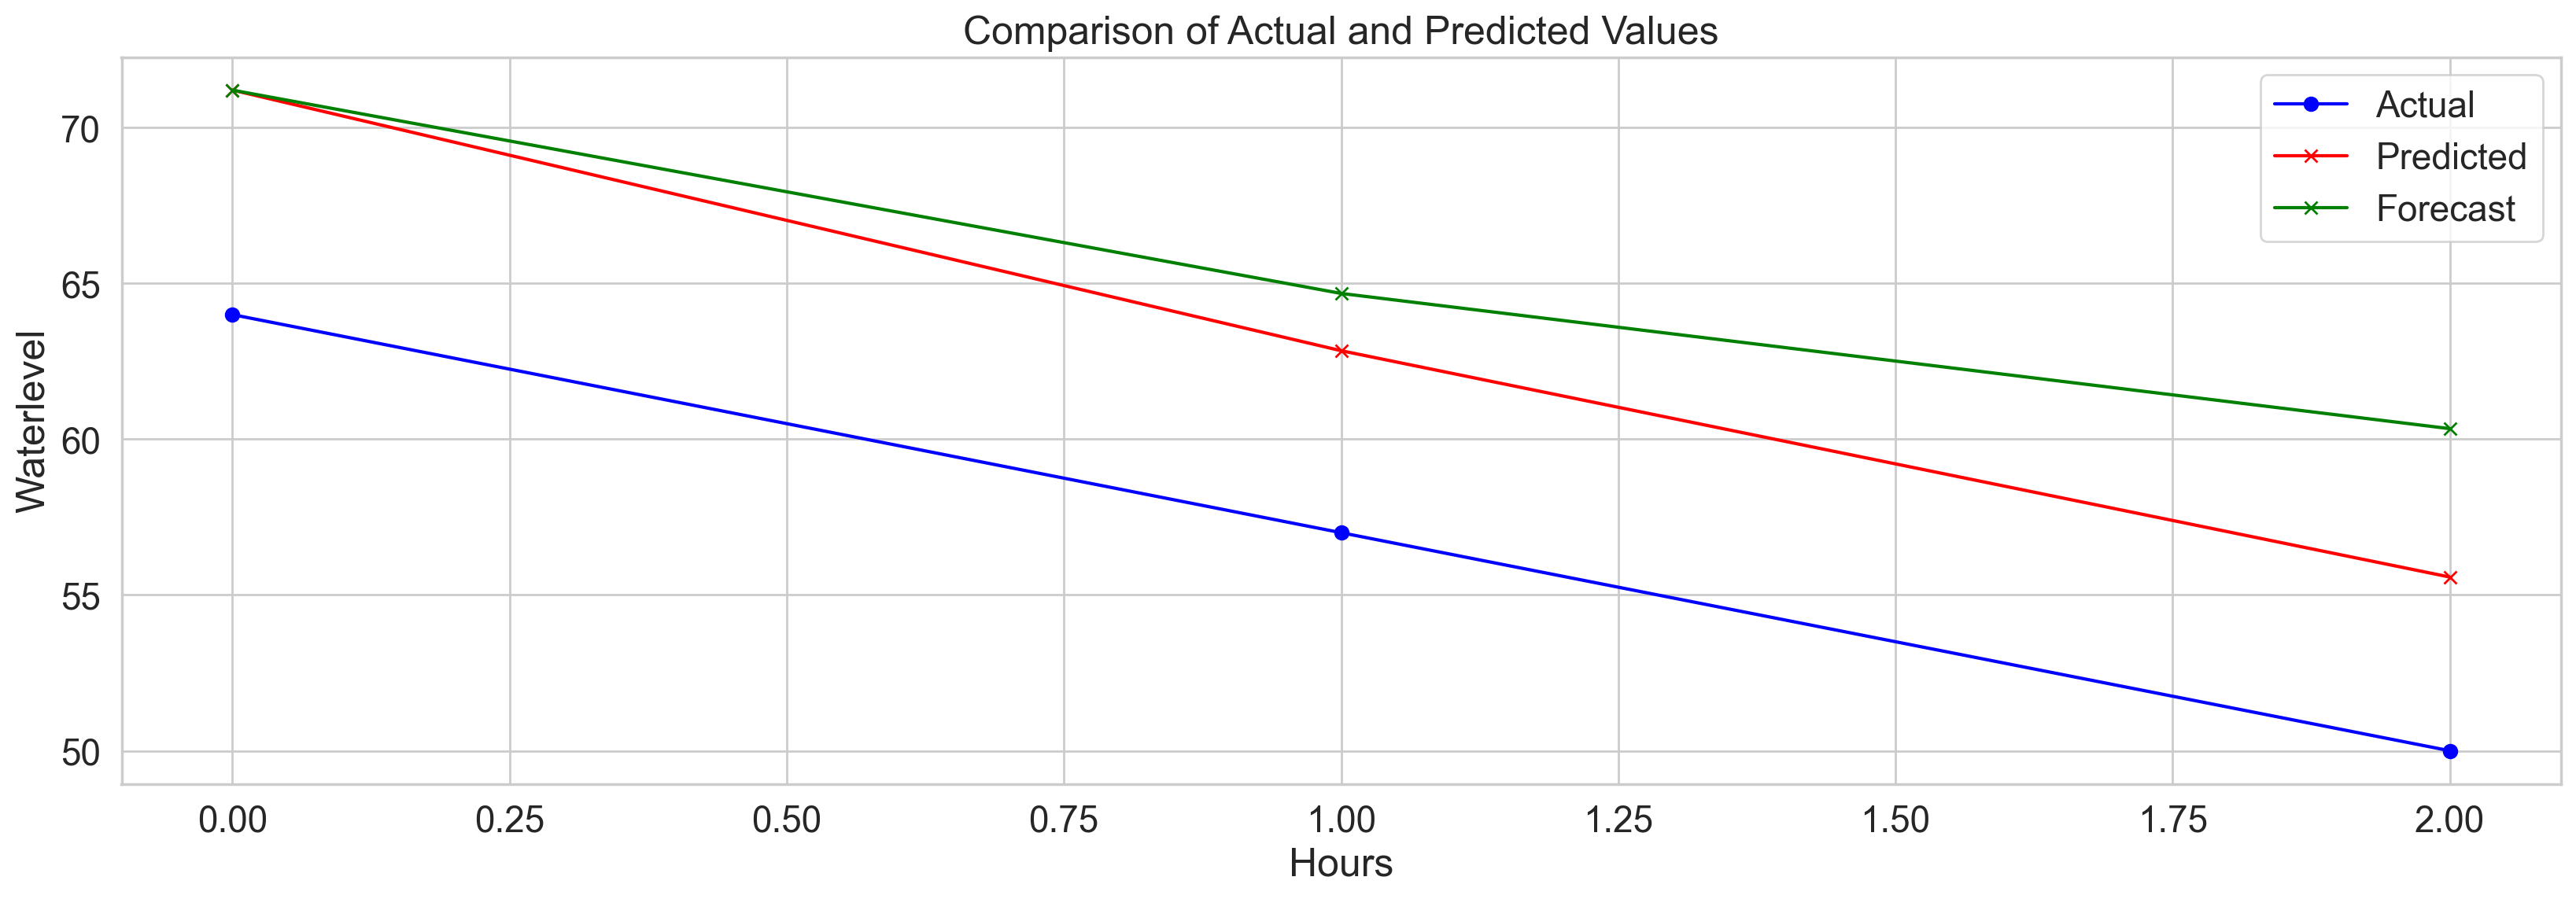

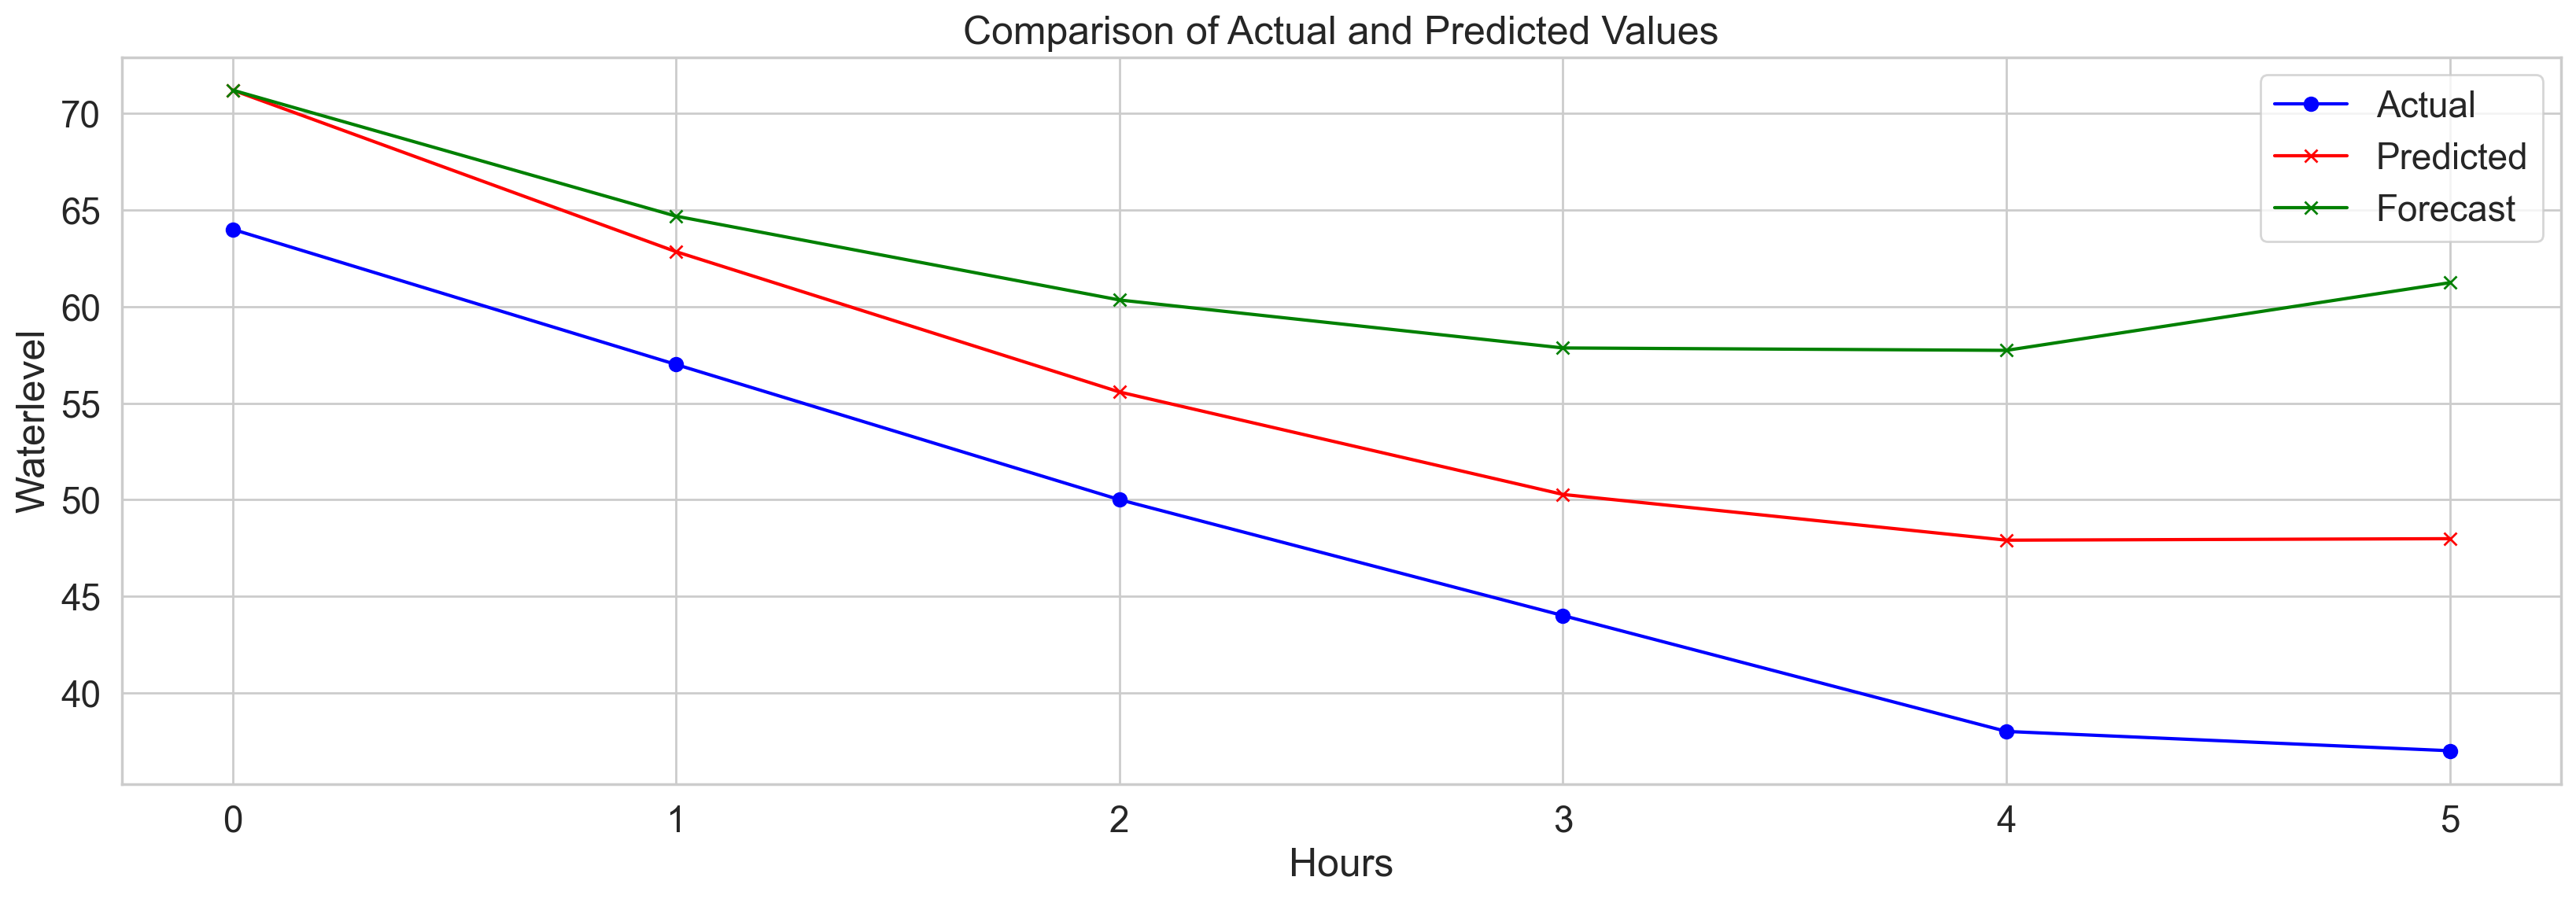

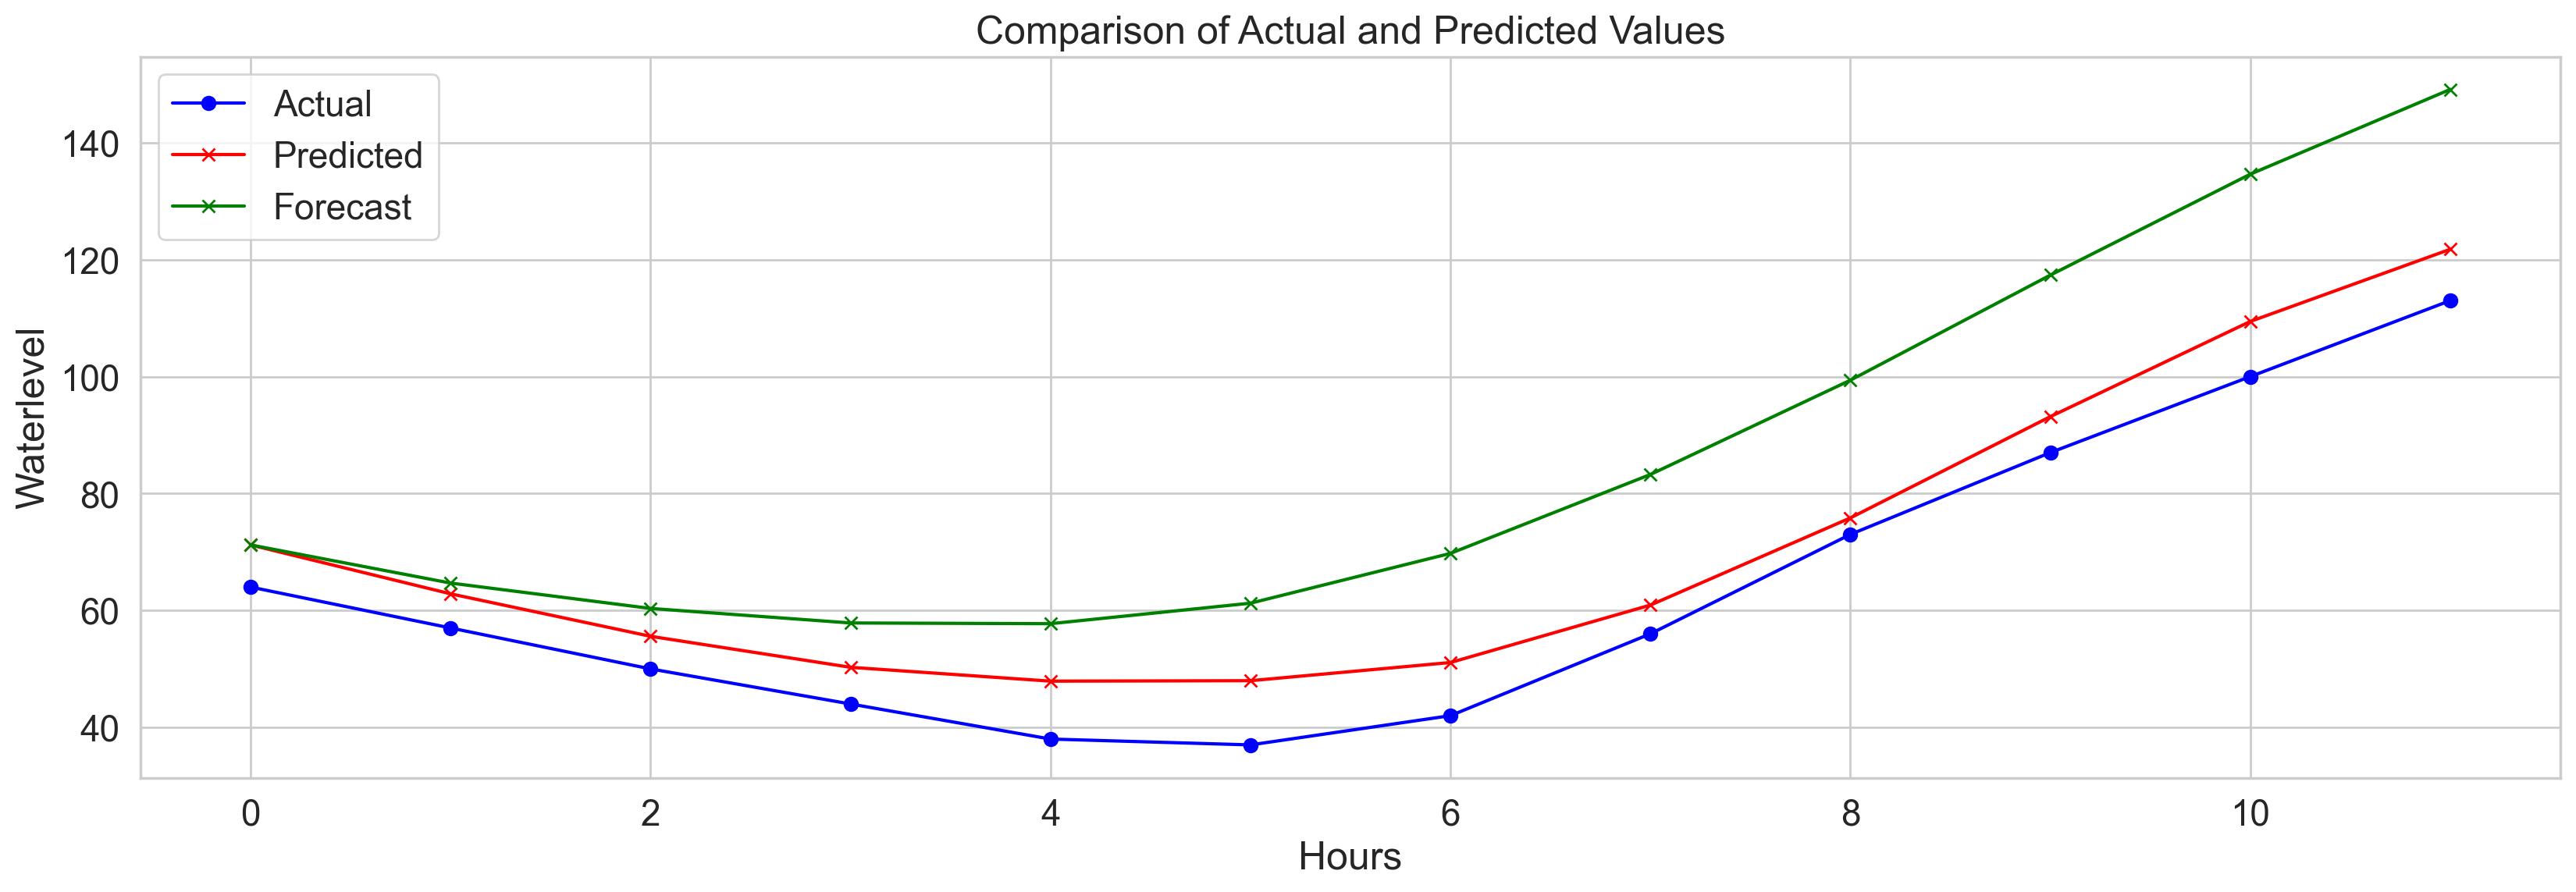

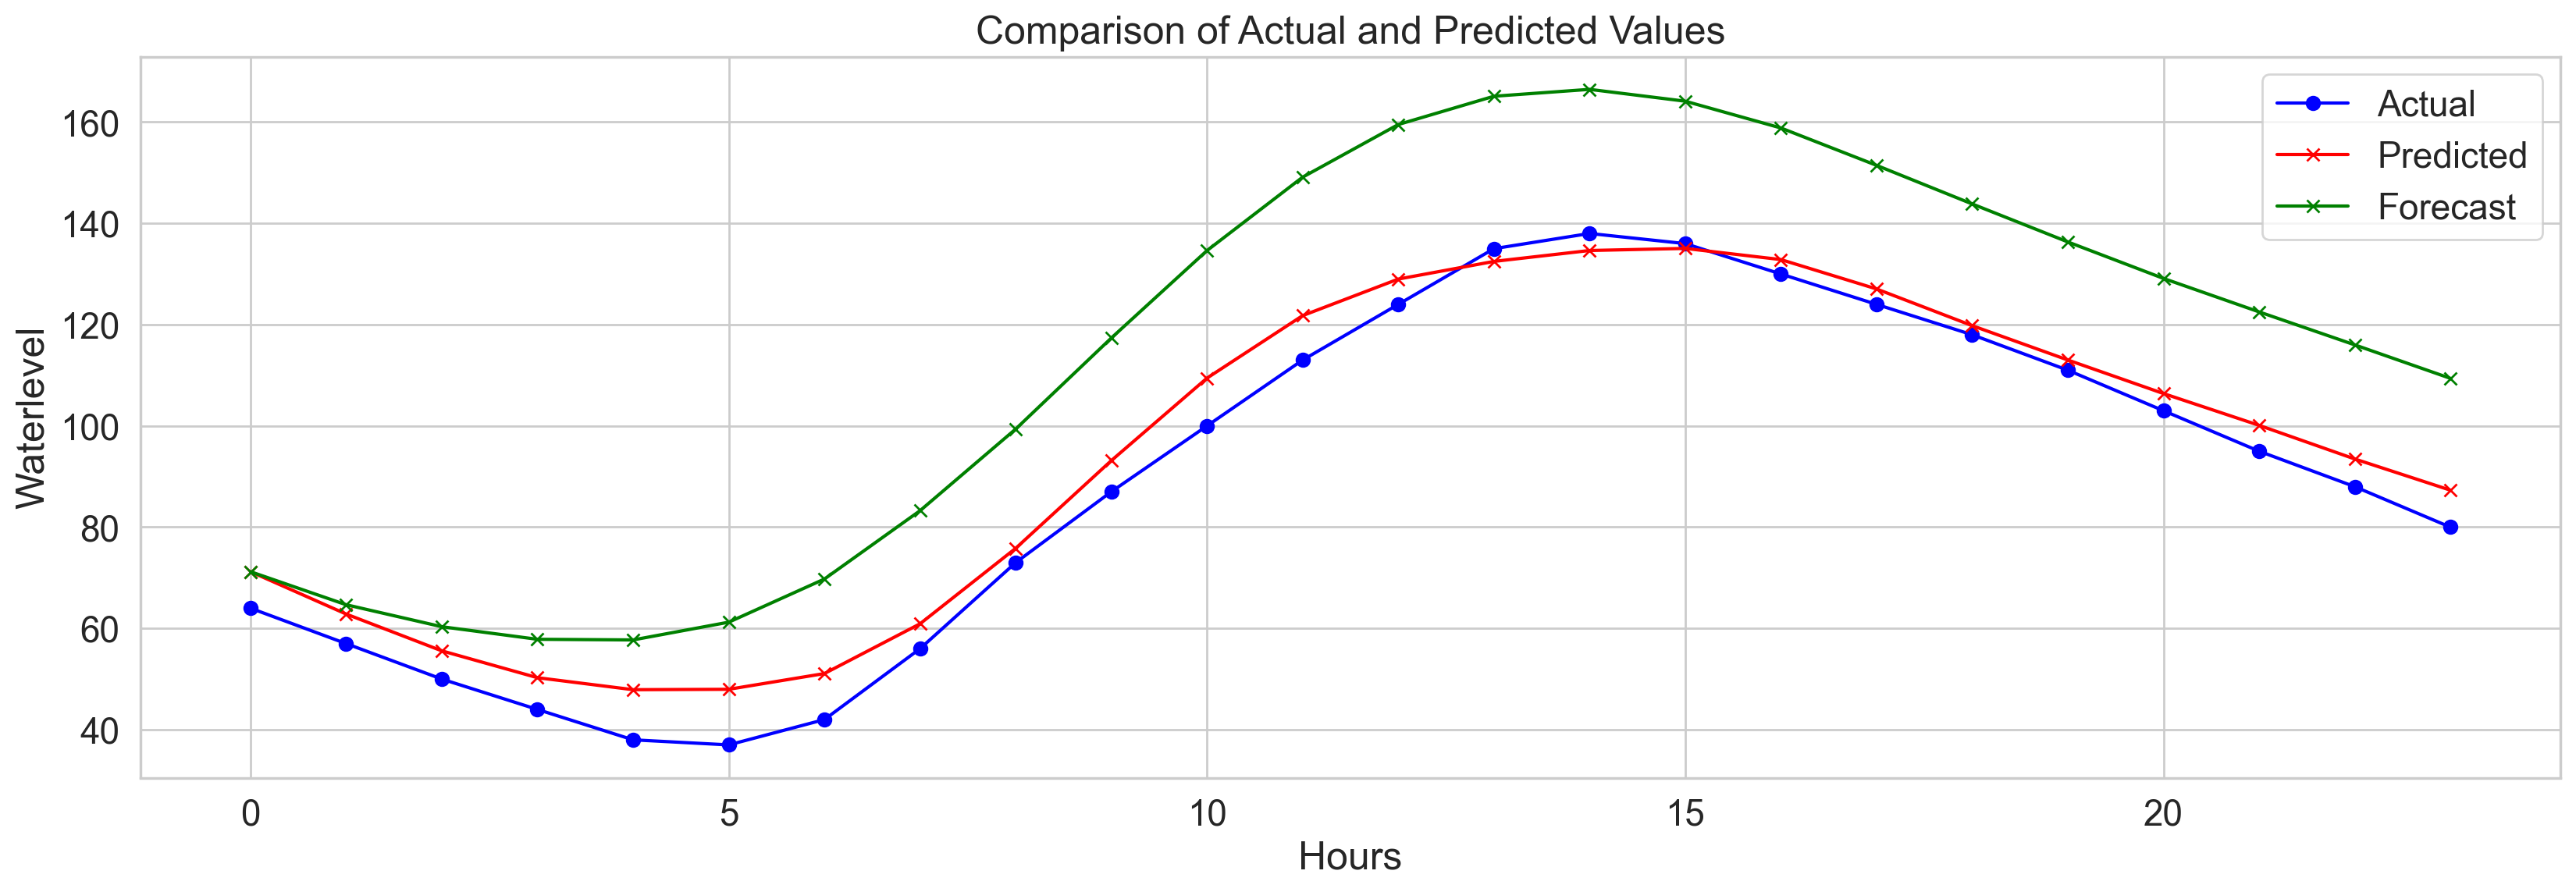

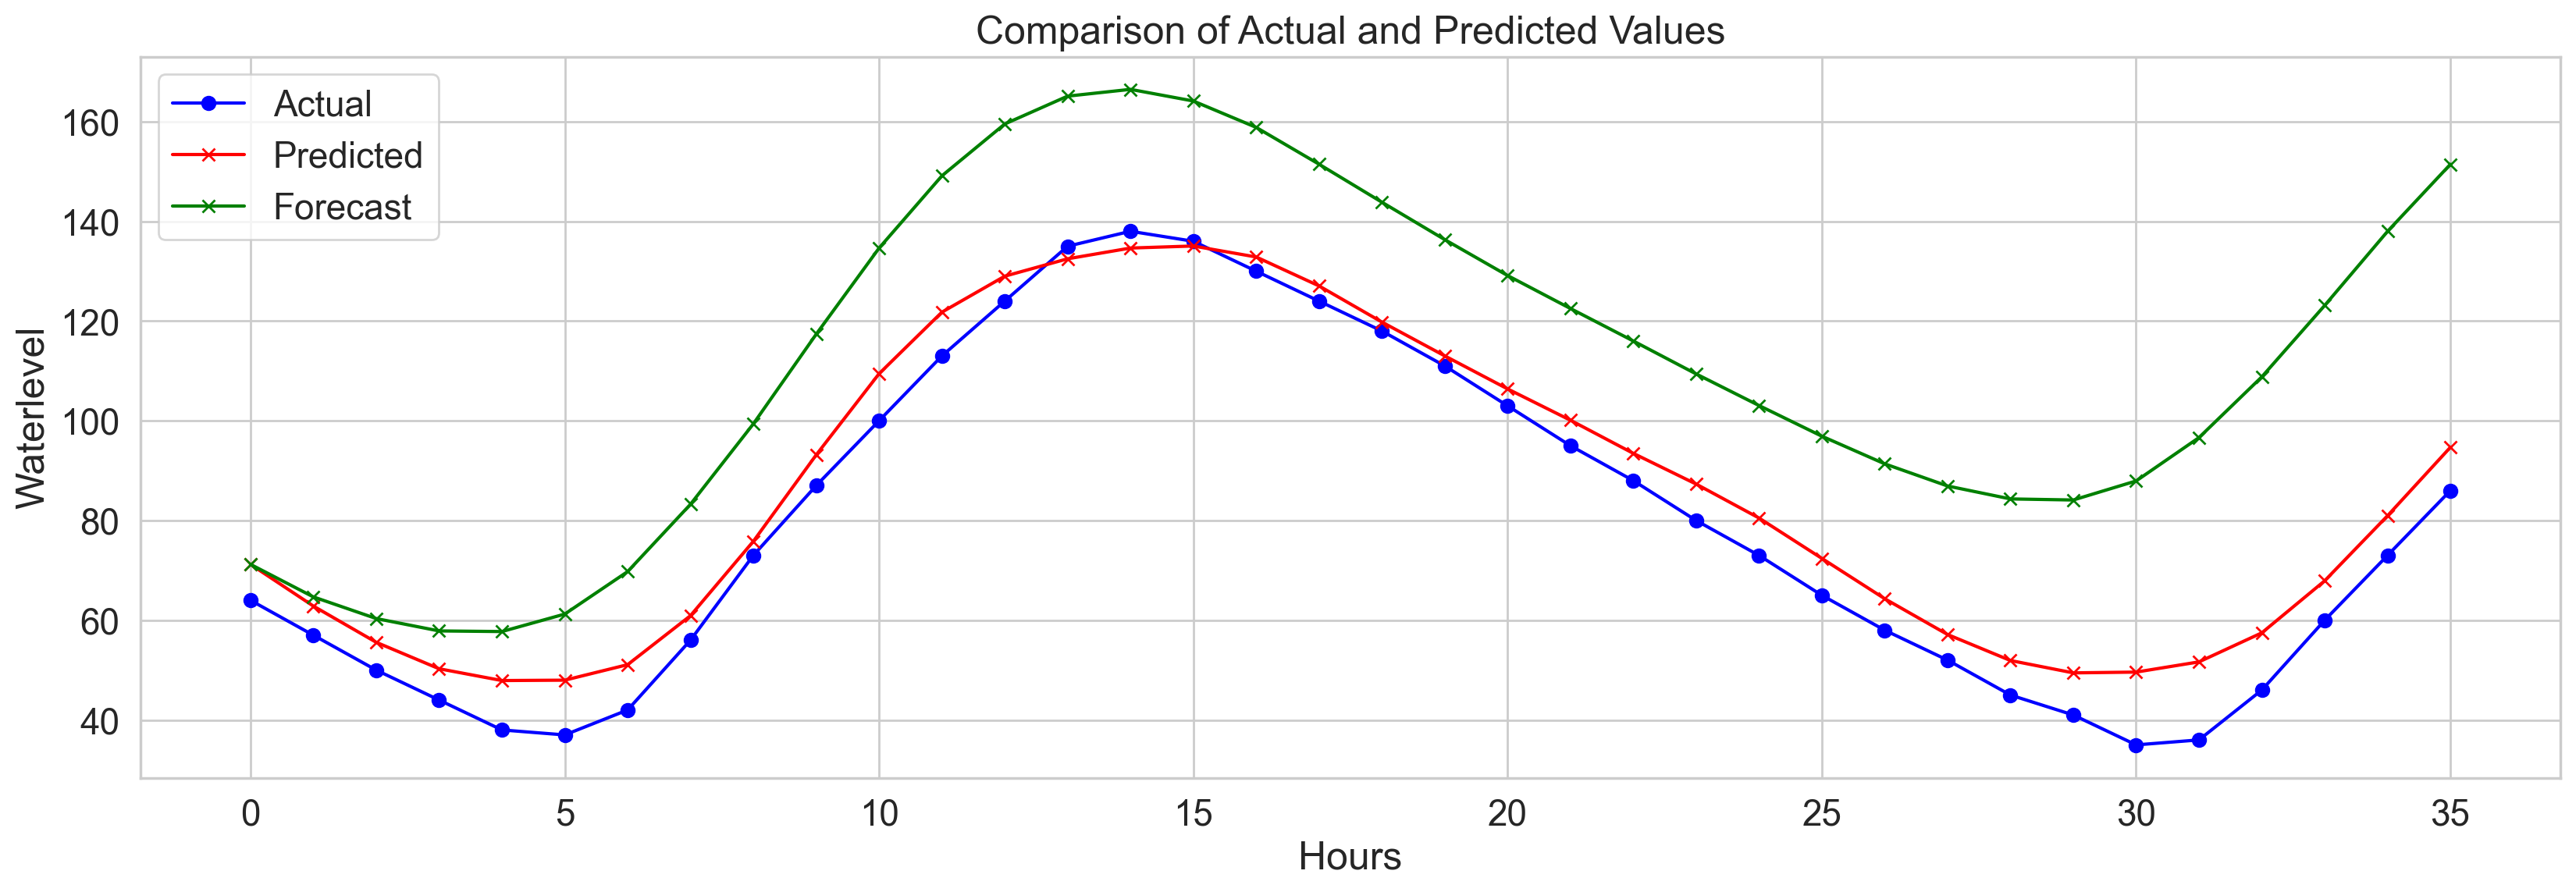

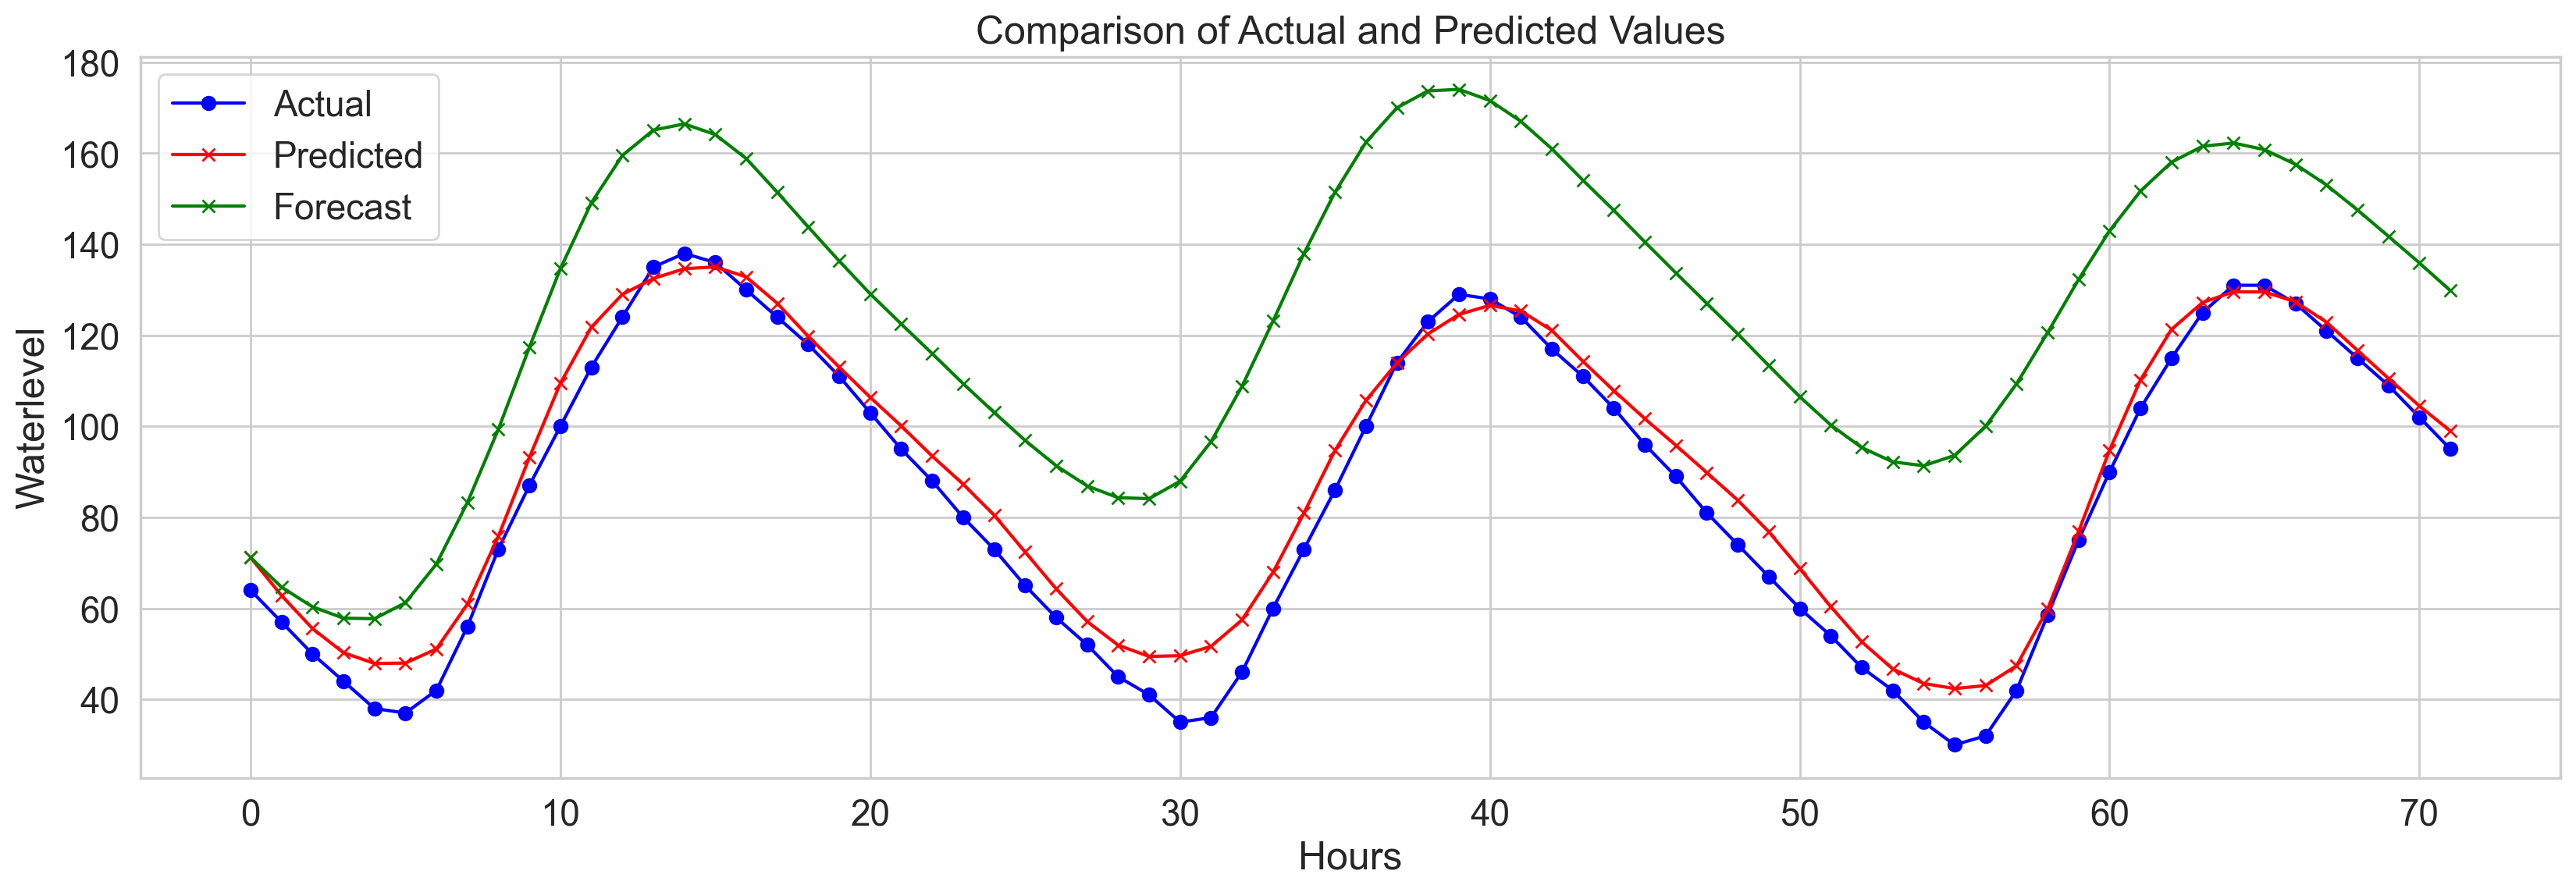

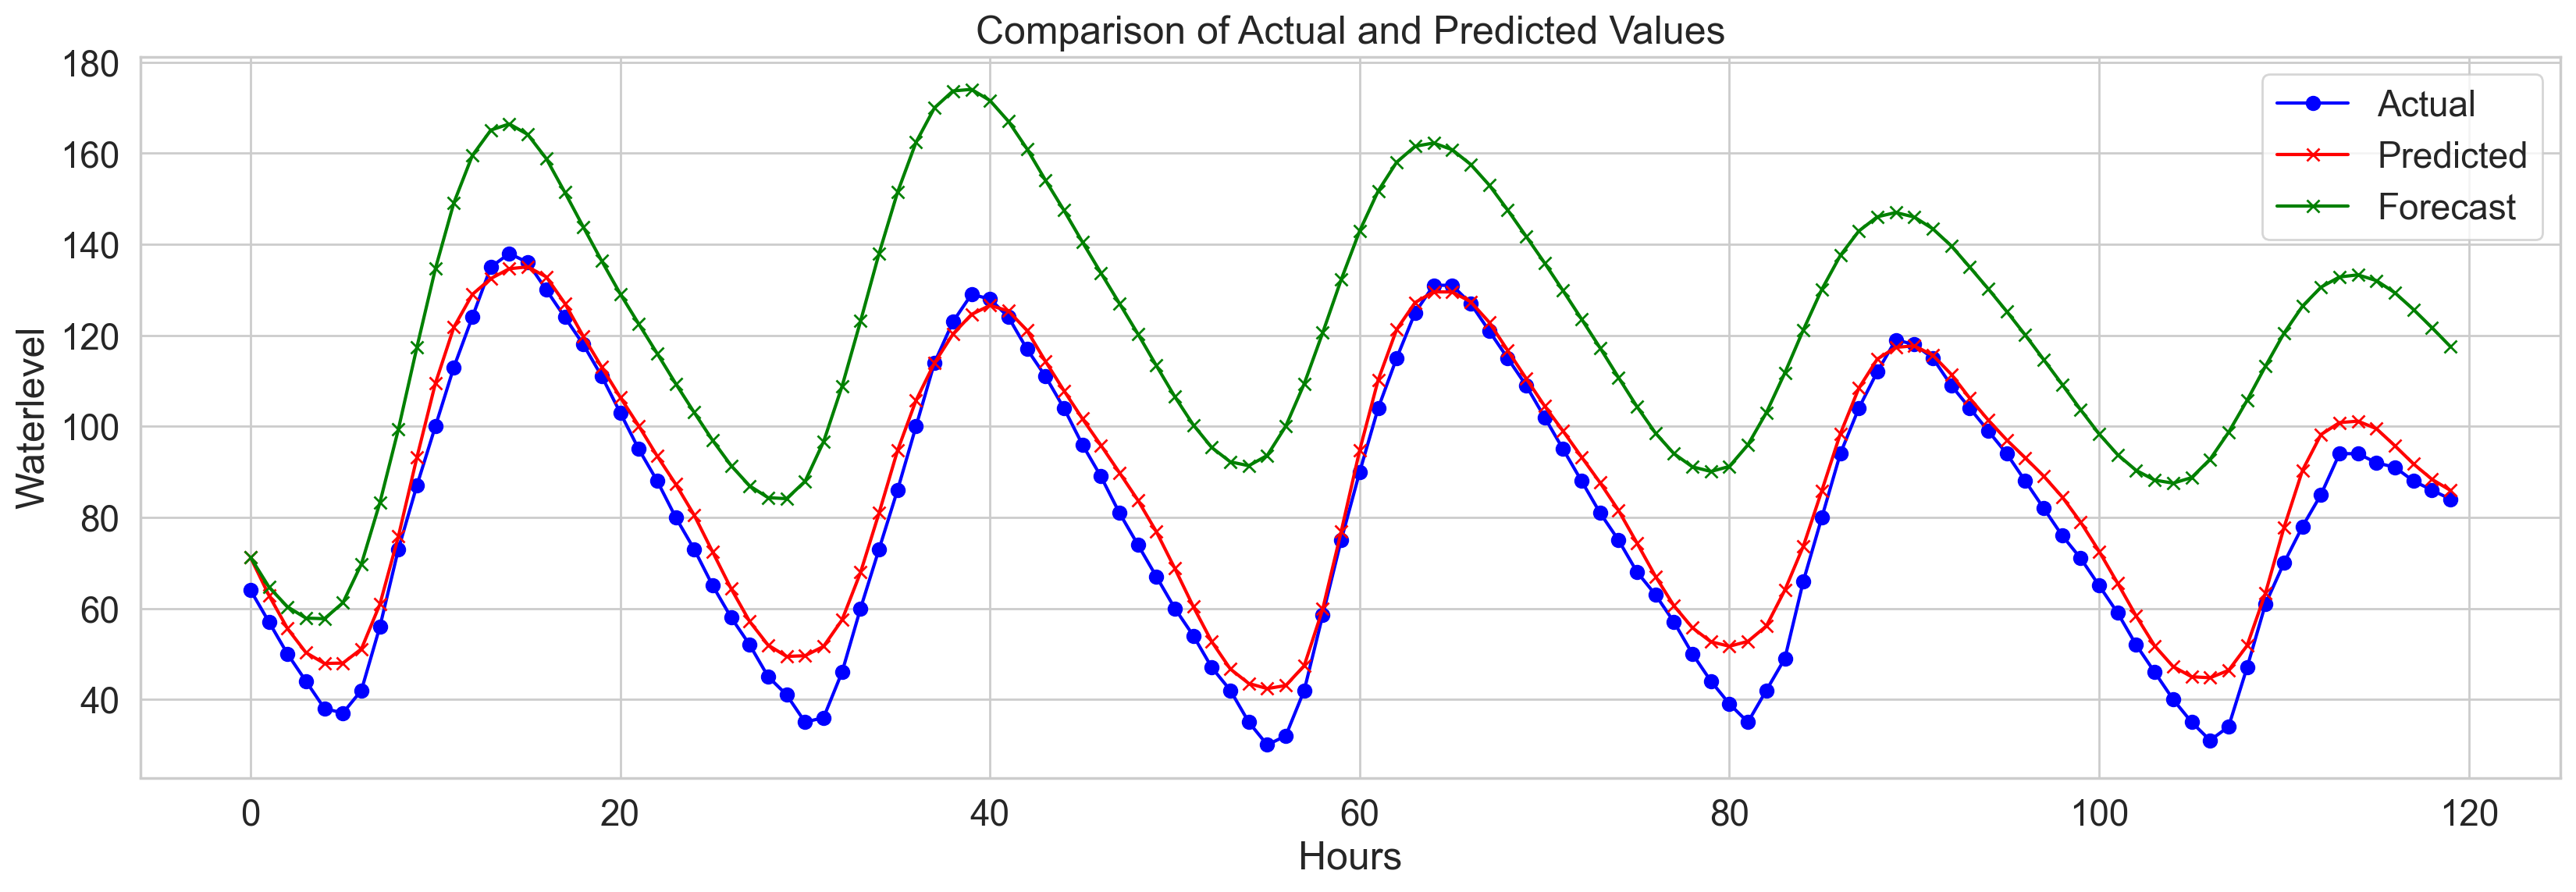

     Size  SIM   MAE  RMSE  FSD    R   NSE     MSE
  3 hours 0.63  8.41  8.52 1.92 0.99 -1.22   72.60
  6 hours 0.68 13.84 15.20 1.93 0.86 -1.40  231.07
 12 hours 0.78 22.13 24.19 1.99 0.97 -0.02  584.99
 24 hours 0.80 25.26 26.43 1.99 0.99  0.38  698.74
 36 hours 0.77 33.02 36.26 1.99 0.90 -0.21 1315.00
 72 hours 0.74 39.62 42.18 1.99 0.90 -0.62 1779.04
120 hours 0.73 40.41 42.45 1.99 0.91 -0.94 1801.98


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3060\1137613382.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)


In [30]:
y_fc = forecast(model, hours, time)
y_pred = model.predict(x_test[time:])

y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)
y_fc_original = scaler.inverse_transform(y_fc)

time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    plt.figure(figsize=(20, 6))
    
    plt.plot(y_test_original[time : time + hours].flatten(), label='Actual', color='blue', marker='o')
    plt.plot(y_pred_original[: hours], label='Predicted', color='red', marker='x')
    plt.plot(y_fc_original[: hours].flatten(), label='Forecast', color='green', marker='x')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Hours')
    plt.ylabel('Waterlevel')
    plt.legend()

    plt.show()
    

metrics_df = pd.DataFrame(columns=["Size", "SIM", "MAE", "RMSE", "FSD", "R", "NSE", "MSE"])
for hours in time_forecast:
    
    metrics = calculate_metrics(y_test_original[time : time + hours].flatten(), y_fc_original[:hours].flatten())
  
    metrics['Size'] = f'{hours} hours'
    metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)
metrics_df = metrics_df.round(2)    
print(metrics_df.to_string(index=False))